In [1]:
# Super global constant variables
BOARD_ROW = 6
BOARD_COL = 7

In [2]:
import numpy as np
import random

class Connect4Env:
    def __init__(self):
        self.rows = BOARD_ROW
        self.cols = BOARD_COL
        self.board = np.zeros((self.rows, self.cols), dtype = np.int8)
        self.current_player = 1  # Player 1 = 1, Player 2 = 2
        self.reward = {'win': 10, 'draw': 0, 'lose': -10}

    def reset(self):
        self.__init__()
        return self.board.flatten()

    def play(self, action):
        """Thực hiện một hành động"""
        if action not in self.valid_moves():
            return self.board.flatten(), -10, True, {}  # Kết thúc nếu chọn sai

        for row in reversed(range(self.rows)):  # Tìm hàng trống thấp nhất
            if self.board[row, action] == 0:
                self.board[row, action] = self.current_player
                reward, done = self.isWinningMove()
                self.current_player = 3 - self.current_player  # Đổi lượt
                return self.board.flatten(), reward, done, {}

        return self.board.flatten(), -10, True, {}  # Kết thúc nếu cột đầy
    
    """ Check if current state is ended after making a move"""
    def isWinningMove(self):
        def check_direction(r, c, dr, dc, player):
            count = 0
            for _ in range(4):
                if 0 <= r < self.rows and 0 <= c < self.cols and self.board[r, c] == player:
                    count += 1
                    r += dr
                    c += dc
                else:
                    break
            return count == 4

        for r in reversed(range(self.rows)):
            for c in range(self.cols):
                if self.board[r, c] != 0:
                    player = self.board[r, c]
                    if (check_direction(r, c, 1, 0, player) or  # Vertical
                            check_direction(r, c, 0, 1, player) or  # Horizontal
                            check_direction(r, c, 1, 1, player) or  # Diagonal /
                            check_direction(r, c, 1, -1, player)):  # Diagonal \
                        return (self.reward['win'], True)
                    
        # Check draw game
        if np.all(self.board != 0):
            return (self.reward['draw'], True)
        
        return (0, False) # have not done yet

    def valid_moves(self):
        """Trả về danh sách cột có thể đi"""
        return [c for c in range(self.cols) if self.board[0, c] == 0]
    
    def printBoard(self):
        for row in self.board:
            print(" ".join(["⚫" if x == 0 else "🚗" if x == 1 else "🚕" for x in row]))
        print(" 0  1   2  3   4  5   6")

board = Connect4Env()
state = board.reset()
print(state)
print(board.board)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)  # Không dùng softmax vì DQN tối ưu giá trị Q


0.13815510557964272
[1.         0.88386723 0.78271982 0.6946241  0.61789594 0.55106851
 0.49286425 0.44217046 0.39801801 0.35956284 0.32606978 0.29689855
 0.27149146 0.24936282 0.23008958 0.21330329 0.19868304 0.18594933
 0.17485874 0.16519924 0.15678616 0.14945868 0.14307671 0.13751824
 0.13267702 0.1284605  0.12478806 0.1215895  0.11880367 0.11637731
 0.11426404 0.11242346 0.11082038 0.10942416 0.1082081  0.10714895
 0.10622648 0.10542304 0.10472327 0.10411379 0.10358296 0.10312063
 0.10271796 0.10236724 0.10206178 0.10179574 0.10156402 0.10136221
 0.10118643 0.10103334]


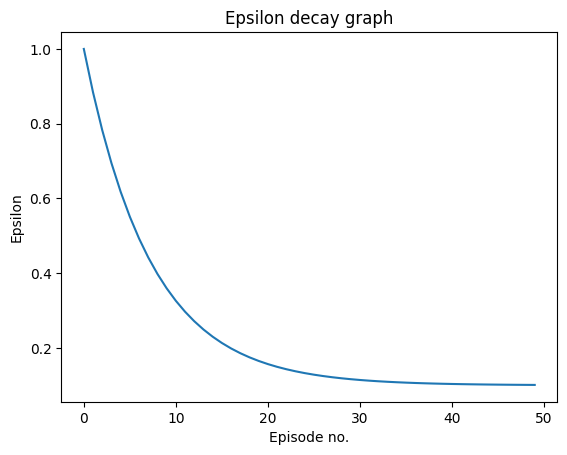

In [4]:
import matplotlib.pyplot as plt
# epilson decay graph
epsilon_start = 1.0
epsilon_end = 0.1

max_episode = 50
episode = np.arange(max_episode)
epsilon_decay = np.log(epsilon_start/epsilon_end*100) / max_episode

eps = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode * epsilon_decay)
plt.plot(episode, eps)
print(epsilon_decay)
print(eps)
plt.title('Epsilon decay graph')
plt.xlabel('Episode no.')
plt.ylabel('Epsilon')
plt.show()

In [5]:
""" Use Epsilon-greedy to find out the best way to make a move

    @Params:
    @Return: best column to play"""
def select_action(model, state, episode=None, training=True):
    valid_moves = env.valid_moves()
    if not training:  
        with torch.no_grad():
            q_values = model(torch.tensor(state, dtype=torch.float32))
            return valid_moves[torch.argmax(q_values[valid_moves]).item()]
    """ Select action using epsilon-greedy with decay.
        Calculate epsilon based on episode if training, otherwise no exploration"""
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode * epsilon_decay) if training else 0.0

    valid_moves = env.valid_moves()  # Lấy danh sách các cột hợp lệ

    if random.random() < epsilon:
        return np.random.choice(valid_moves)  # Chọn ngẫu nhiên trong các cột hợp lệ
    else:
        with torch.no_grad():
            q_values = model(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
            return torch.argmax(q_values).item()


In [6]:
""" Let 2 models play against each other
    @Return: reward after play optimally"""
def play_game(dqn_player1, dqn_player2, env, epsilon):
    state = env.reset()
    done = False
    turn = 1  # 1 là Player 1, 2 là Player 2

    while not done:
        model = dqn_player1 if turn == 1 else dqn_player2
        action = select_action(model, state, epsilon)
        
        next_state, reward, done, _ = env.step(action)

        if done:
            return reward  # Trả về kết quả trận đấu

        state = next_state
        turn = 3 - turn  # Đổi lượt chơi


In [7]:
from collections import deque

"""@Params: """
def train_model(model, optimizer, memory, batch_size):
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    
    for state, action, reward, next_state, done in batch:
        q_values = model(torch.tensor(state, dtype=torch.float32))
        q_value = q_values[action]

        with torch.no_grad():
            next_q_values = model(torch.tensor(next_state, dtype=torch.float32))
            target_q_value = reward if done else reward + 0.99 * torch.max(next_q_values)

        loss = (q_value - target_q_value) ** 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [8]:
import time

env = Connect4Env()

input_dim = BOARD_ROW * BOARD_COL  # Size of board
output_dim = BOARD_COL  # Ouput action (column 0 -> n)

dqn_player1 = DQN(input_dim, output_dim)
dqn_player2 = DQN(input_dim, output_dim)

optimizer1 = optim.Adam(dqn_player1.parameters(), lr=0.001)
optimizer2 = optim.Adam(dqn_player2.parameters(), lr=0.001)

memory = deque(maxlen=10000)
batch_size = 64
num_episodes = 50
epsilon = 0.1
startTime = time.time()

for episode in range(num_episodes):
    state = env.reset()
    done = False
    turn = 1  # 1 là Player 1, 2 là Player 2

    while not done:
        model = dqn_player1 if turn == 1 else dqn_player2
        optimizer = optimizer1 if turn == 1 else optimizer2

        valid_moves = env.valid_moves()
        if not valid_moves:
            break  

        action = select_action(model, state, epsilon)
        next_state, reward, done, _ = env.play(action)

        memory.append((state, action, reward, next_state, done))
        train_model(model, optimizer, memory, batch_size)

        state = next_state
        turn = 3 - turn  # Đổi lượt chơi

    # Ghi lại kết quả trận đấu
    if done:
        if reward == 10:
            if turn == 1:
                player1_wins += 1
            else:
                player2_wins += 1
        else:
            draws += 1

    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode * epsilon_decay)

    # Đánh giá và in thông tin mỗi 10 episode
    if episode % 10 == 0:
        print(f"Episode {episode}: Reward {reward}, Epsilon {epsilon:.4f}")
        print(f"Training Stats - P1 Wins: {player1_wins}, P2 Wins: {player2_wins}, Draws: {draws}")
        win_rate, avg_win_steps, avg_total_reward = evaluate_model(dqn_player1, env, num_games=10)
        print(f"Evaluate at Episode {episode}: Win Rate {win_rate:.2%}, Avg Win Steps {avg_win_steps:.2f}, Avg Reward {avg_total_reward:.2f}")

endTime = time.time()
print(f"Trained {num_episodes} episodes after {endTime-startTime:.4f} seconds")
print("Training complete!")

NameError: name 'player1_wins' is not defined

In [ ]:
def evaluate_model(model, env, num_games=100):
    total_wins = 0
    total_losses = 0
    total_draws = 0
    total_win_steps = 0
    total_rewards = 0

    for _ in range(num_games):
        state = env.reset()
        done = False
        current_player = 1  # Model là Player 1
        steps = 0
        winner = None
        final_reward = 0

        while not done:
            steps += 1
            valid_moves = env.valid_moves()
            
            # Chọn hành động
            if current_player == 1:
                action = select_action(model, state, training=False)
            else:
                action = random.choice(valid_moves)  # Đối thủ ngẫu nhiên
            
            # Thực hiện hành động
            next_state, reward, done, _ = env.play(action)
            
            # Ghi lại thông tin khi kết thúc game
            if done:
                final_reward = reward
                last_player = current_player
            
            state = next_state
            current_player = 3 - current_player  # Đổi lượt

        # Xác định kết quả từ góc nhìn của model
        if final_reward == env.reward['win']:
            winner = last_player
        elif final_reward == env.reward['draw']:
            winner = None
        else:
            winner = None  # Trường hợp không hợp lệ (không xảy ra khi đánh giá)

        # Cập nhật thống kê
        if winner == 1:
            total_wins += 1
            total_win_steps += steps
            total_rewards += env.reward['win']
        elif winner == 2:
            total_losses += 1
            total_rewards += env.reward['lose']
        else:
            total_draws += 1
            total_rewards += env.reward['draw']

    # Tính toán các chỉ số
    win_rate = total_wins / num_games
    loss_rate = total_losses / num_games
    draw_rate = total_draws / num_games
    avg_win_steps = total_win_steps / total_wins if total_wins > 0 else 0
    avg_total_reward = total_rewards / num_games

    # In kết quả
    print(f"📊 Evaluate on {num_games} game:")
    print(f"✅ Win: {total_wins} ({win_rate:.1%})")
    print(f"❌ Lose: {total_losses} ({loss_rate:.1%})")
    print(f"🤝 Draw: {total_draws} ({draw_rate:.1%})")
    print(f"🎯 Avg Win Steps: {avg_win_steps:.2f}")
    print(f"💰 Avg Total Reward: {avg_total_reward:.2f}")

    return win_rate, avg_win_steps, avg_total_reward

In [ ]:
torch.save(dqn_player1.state_dict(), "dqn_player1.pth")
torch.save(dqn_player2.state_dict(), "dqn_player2.pth")
print("✅ Model saved successfully!")


In [ ]:
# import time

# env = Connect4Env()

# input_dim = BOARD_ROW * BOARD_COL  # Size of board
# output_dim = BOARD_COL  # Ouput action (column 0 -> n)

# dqn_player1 = DQN(input_dim, output_dim)
# dqn_player2 = DQN(input_dim, output_dim)

dqn_player1.load_state_dict(torch.load("dqn_player1.pth"))
dqn_player2.load_state_dict(torch.load("dqn_player2.pth"))
print("✅ Model loaded successfully!")

In [ ]:
start_time = time.time()
evaluate_model(dqn_player1, env, num_games=100)
end_time = time.time()

print(f"⏳ Time taken: {end_time - start_time:.2f} seconds")
